<a href="https://colab.research.google.com/github/BhauArage/Fake-News/blob/main/FakeNewsBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Packages**

In [1]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


**Reading Dataset**

In [3]:
df=pd.read_csv('data.csv')
df.columns = ['URLs','Headline','Body','Label']
del df['URLs']
del df['Headline']
df = df.fillna('No data')
df.head(10)

,Body,Label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1
5,JetNation FanDuel League; Week 4\n% of readers...,0
6,"In 2012, Kansas lawmakers, led by Gov. Sam Bro...",1
7,The Reserve Bank of India (RBI) Governor Urjit...,1
8,"Scott Pruitt, Administrator of the U.S. Enviro...",1
9,FILE PHOTO - An Air Berlin sign is seen at an ...,1


In [4]:
df.Label.unique()

array([1, 0])

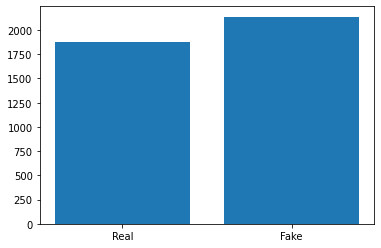

In [5]:
classes = df.Label.unique()
counts=[]
for i in classes:
  count=len(df[df.Label==i])
  counts.append(count)

plt.bar(["Real","Fake"],counts)
plt.show()

**Train Test Split**

In [6]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.Body.values
y = sampleDf.Label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

**Encoding**

In [7]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

**Tokenization**

In [8]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [10]:
do_lower_case

False

In [11]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [12]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

In [13]:
articles = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [14]:
print('Tokenized articles shape', articles.shape.as_list())

Tokenized articles shape [160, None]


In [15]:
articles[0]

<tf.Tensor: shape=(507,), dtype=int32, numpy=
array([ 12225,  61806,  35248,  28927,  10107,  11469,  15682,  13656,
        10117,  15835,  10575,  10715,  10667,  12613,  11597,  14957,
        91497,    100,  17144,    100,    187,  14439,  28844,    100,
          113,  19318,  10377,    112,    187,  12219,    114,  12225,
        61806,  11337,  26092,  12541,  10157,  10114,  20412,  10575,
        10715,  16379,  12166,  10105,  11356,  10169,  10226,  23005,
        47898,  10123,  10751,  11376,    117,    112,  17144,    112,
          187,  14439,  28844,    119,    112,  50195,  19034,  52991,
        10226,  21161,  77869,  10106,  69262,  97656,    117,  33068,
        14446,    155,  10115,  11274,  18791,  11049,  10146,    112,
          146,  48655,    112,  12225,  25720,  68318,  11709,  13956,
        16216,  10146,  10105,  40699,  10142,  10226,  50908,  14946,
          119,  10882,  17864,  10146,    112,  17144,    112,    187,
        14439,  28844,    112, 

In [16]:
x_train[0]

"Carl Thornton Prepares To Light Up The Dancefloor With His Summer Anthem ‘Let’s Go Crazy’\n(Before It's News)\nCarl Thornton will bring joy to dancefloors around the world with his jubilant new single, 'Let's Go Crazy.' Having already displayed his vocal talents in fantastic, soulful RnB records such as 'I Remember' Carl chose funkier vibes as the inspiration for his latest hit. As soon as 'Let's Go Crazy' is played anywhere, your feet will start moving to Carl's groove. No other track sounds like one of Carl's songs. His truly unique sound will captivate and delight your eardrums. Studies at The American Academy of Dramatic Arts and The Broadway Dance Center, left Carl well trained in owning the spotlight, a skill he transferred to his music, which owns the dancefloor. Not content with selling out venues across America, Carl has toured across Europe, China, Hong Kong and Dubai. A series of notable blogs have already covered his music as the scale of his talent dawns on the wider musi

In [17]:
tokenizedArticle = tokenizer.tokenize(x_train[0])
for i in tokenizedArticle:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Carl [12225]
Thornton [61806]
Pre [35248]
##pare [28927]
##s [10107]
To [11469]
Light [15682]
Up [13656]
The [10117]
Dance [15835]
##f [10575]
##lo [10715]
##or [10667]
With [12613]
His [11597]
Summer [14957]
Anthem [91497]
[UNK] [100]
Let [17144]
[UNK] [100]
s [187]
Go [14439]
Crazy [28844]
[UNK] [100]
( [113]
Before [19318]
It [10377]
' [112]
s [187]
News [12219]
) [114]
Carl [12225]
Thornton [61806]
will [11337]
bring [26092]
jo [12541]
##y [10157]
to [10114]
dance [20412]
##f [10575]
##lo [10715]
##ors [16379]
around [12166]
the [10105]
world [11356]
with [10169]
his [10226]
ju [23005]
##bilan [47898]
##t [10123]
new [10751]
single [11376]
, [117]
' [112]
Let [17144]
' [112]
s [187]
Go [14439]
Crazy [28844]
. [119]
' [112]
Having [50195]
already [19034]
displayed [52991]
his [10226]
vocal [21161]
talents [77869]
in [10106]
fant [69262]
##astic [97656]
, [117]
soul [33068]
##ful [14446]
R [155]
##n [10115]
##B [11274]
records [18791]
such [11049]
as [10146]
' [112]
I [146]
Remember 

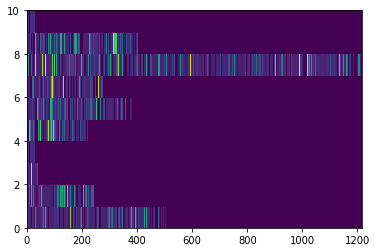

In [18]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*articles.shape[0]
input_word_ids = tf.concat([cls, articles], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

**Mask And Input ids**

In [19]:
input_word_ids

<tf.RaggedTensor [[101, 12225, 61806, 35248, 28927, 10107, 11469, 15682, 13656, 10117, 15835, 10575, 10715, 10667, 12613, 11597, 14957, 91497, 100, 17144, 100, 187, 14439, 28844, 100, 113, 19318, 10377, 112, 187, 12219, 114, 12225, 61806, 11337, 26092, 12541, 10157, 10114, 20412, 10575, 10715, 16379, 12166, 10105, 11356, 10169, 10226, 23005, 47898, 10123, 10751, 11376, 117, 112, 17144, 112, 187, 14439, 28844, 119, 112, 50195, 19034, 52991, 10226, 21161, 77869, 10106, 69262, 97656, 117, 33068, 14446, 155, 10115, 11274, 18791, 11049, 10146, 112, 146, 48655, 112, 12225, 25720, 68318, 11709, 13956, 16216, 10146, 10105, 40699, 10142, 10226, 50908, 14946, 119, 10882, 17864, 10146, 112, 17144, 112, 187, 14439, 28844, 112, 10124, 11553, 11178, 30935, 117, 20442, 17296, 11337, 15148, 23557, 10114, 12225, 112, 187, 30518, 22659, 10612, 119, 10657, 10684, 14310, 55434, 11850, 10464, 10108, 12225, 112, 187, 15457, 119, 11597, 92755, 18223, 19302, 11337, 13337, 109369, 10112, 10111, 10127, 27521, 2

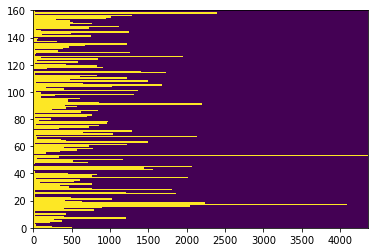

In [20]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

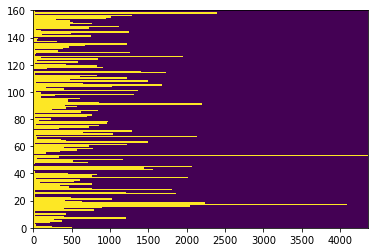

In [21]:
type_cls = tf.zeros_like(cls)
type_article = tf.ones_like(articles)
input_type_ids = tf.concat([type_cls, type_article], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [22]:
input_type_ids

<tf.Tensor: shape=(160, 4363), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

**Function to return the 3 arguments easily**

In [23]:
max_seq_length=512

In [24]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [25]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

**Training**

In [27]:
num_class = len(encoder.classes_)
max_seq_length = max_seq_length   # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

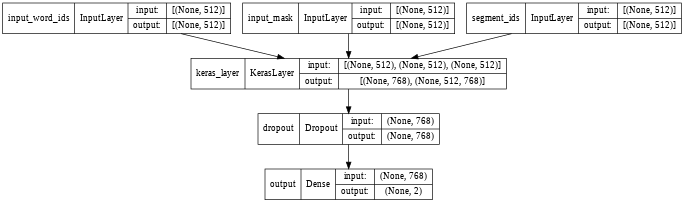

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [29]:
epochs = 3
batch_size = 6  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [30]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

In [32]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test))

Epoch 1/3
27/27 [==============================] - 66s 2s/step - loss: 0.5639 - accuracy: 0.6938 - val_loss: 0.3021 - val_accuracy: 0.9500
Epoch 2/3
27/27 [==============================] - 45s 2s/step - loss: 0.1539 - accuracy: 0.9438 - val_loss: 0.2046 - val_accuracy: 0.9500
Epoch 3/3
27/27 [==============================] - 44s 2s/step - loss: 0.0368 - accuracy: 0.9937 - val_loss: 0.1846 - val_accuracy: 0.9250


In [33]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9250


In [34]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

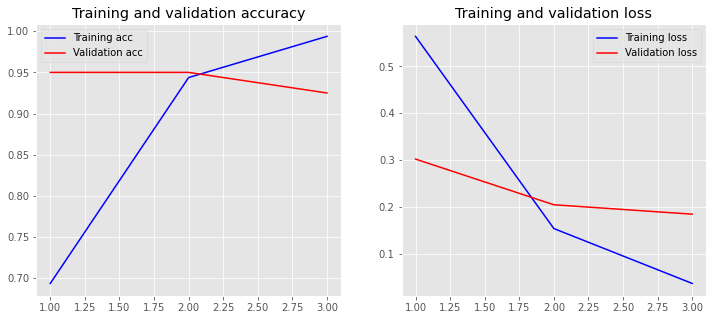

In [35]:
plot_history(history)

**Save Model**

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
model_fname = 'fakenews_BERT'
my_wd = 'drive.google.com/drive/u/0/folders/1lFNzI_vlTtDynWmFaanaV1DbKAL78uyI'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: drive.google.com/drive/u/0/folders/1lFNzI_vlTtDynWmFaanaV1DbKAL78uyI/fakenews_BERT/assets


INFO:tensorflow:Assets written to: drive.google.com/drive/u/0/folders/1lFNzI_vlTtDynWmFaanaV1DbKAL78uyI/fakenews_BERT/assets


**TEST**

In [46]:
NEWS=[' Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations.   Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force.The Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October.'] 
inputs = bert_encode(string_list=list(NEWS), 
                     tokenizer=tokenizer, 
                     max_seq_length=512)

In [47]:
prediction = model.predict(inputs)
print(prediction)
print('NEWS is', 'REAL' if encoder.classes_[np.argmax(prediction)]==1 else 'FAKE')

[[0.99479806 0.00520192]]
NEWS is FAKE
